# Synfire chain growth

The aim of this notebook is to investigate the formation of wide synfire chains via Ila Fiete's recipe of STDP + heterosynaptic competition + correlated input.

## Network Architecture
Conductance-based LIF network. Single-neuron voltage dynamics:

$$C_m \frac{dV}{dt} = g_l[E_l - V(t)] + g_e(t)[E_e - V(t)] + g_i(t)[E_i - V(t)] + I_{ext}(t)$$

The time-varying conductances $g_e(t)$ and $g_i(t)$ are exponentially filtered sums of spike trains from upstream neurons $j$, with time constants $\tau_e$ and $\tau_i$ and weighted by $W_e^{ij}$ and $W_i^{ij}$, respectively (convention: weight to $i$ from $j$):

$$\tau_e\frac{dg^i_e}{dt} = -g^i_e + \sum_j W_e^{ij} \sum_{t_k^j} \delta(t - t_k^j)$$

$$\tau_i\frac{dg^i_i}{dt} = -g^i_i + \sum_j W_i^{ij} \sum_{t_k^j} \delta(t - t_k^j)$$

where $t_k^j$ are the spike times in the $j$-th neuron.

# Code

In [1]:
%matplotlib inline
from copy import deepcopy as copy
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
from scipy.linalg import block_diag
import pandas as pd
from tqdm import tqdm
import pickle
from collections import OrderedDict
import os
from scipy.ndimage.interpolation import shift
from functools import reduce

from aux import Generic
from disp import set_font_size, get_spaced_colors
from ntwk import LIFNtwkG
from utils.general import *

cc = np.concatenate

# PARAMS
## NEURON AND NETWORK MODEL
M = Generic(
    # Excitatory membrane
    C_M_E=1e-6,  # membrane capacitance
    G_L_E=.4e-3,  # membrane leak conductance (T_M (s) = C_M (F/cm^2) / G_L (S/cm^2))
    E_L_E=-.06,  # membrane leak potential (V)
    V_TH_E=-.05,  # membrane spike threshold (V)
    T_R_E=6e-3,  # refractory period (s)
    E_R_E=-0.055, # reset voltage (V)
    
    # Inhibitory membrane
    #C_M_I=1e-6,
    #G_L_E=.1e-3, 
    #E_L_I=-.06,
    #V_TH_E=-.05,
    #T_R_I=.002,
    
    # syn rev potentials and decay times
    E_E=0, E_I=-.07, T_E=.004, T_I=.004,
    
    W_U_E=0.5e-3,
    W_MAX=0.26 * 0.004,
    M=9.,
    ETA=0.00005,
    EPSILON=0.05,
    
    W_E_I_R=0,
    W_I_E_R=0,
    
    N_EXC=50,
    N_INH=1,
    
    DRIVING_HZ=10, # 10 Hz lambda Poisson input to system
    N_DRIVING_CELLS=10,
    PROJECTION_NUM=5,
    W_INITIAL=0.,
    
    # OTHER INPUTS
    SGM_N=.5e-9,  # noise level (A*sqrt(s))
    I_EXT_B=0,  # additional baseline current input
)

## SMLN
S = Generic(RNG_SEED=0, DT=0.1e-3)

print('T_M_E =', 1000*M.C_M_E/M.G_L_E, 'ms')  # E cell membrane time constant (C_m/g_m)

T_M_E = 2.5 ms


## Synaptic weight change under STDP rule

In [2]:
def bin_occurrences(occurrences, min_idx=0, max_idx=None, bin_size=1):
    if max_idx is None:
        max_idx = occurrences.max() + 1
    binned = np.zeros(max_idx - min_idx)
    for n in occurrences:
        if n >= max_idx or n < min_idx:
            raise IndexError(f'index {n} is out of bounds for min {min_idx} and max {max_idx}')
        binned[n - min_idx] += 1
    return binned

def calc_degree_dist(mat):
    degree_freqs = bin_occurrences(np.count_nonzero(mat, axis=1))
    return np.arange(len(degree_freqs)), degree_freqs

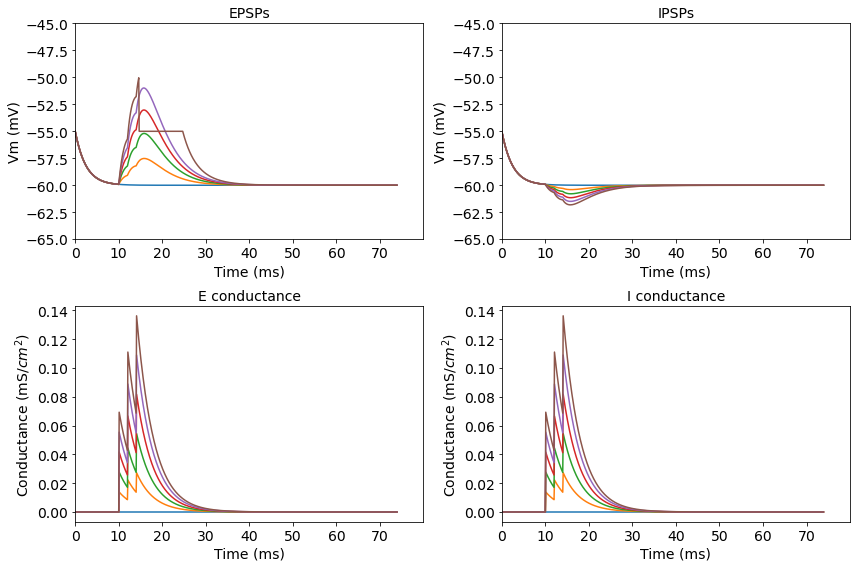

In [3]:
np.random.seed(0)
# EPSP size vs E weight
t = np.arange(0, .08, S.DT)
rsps_e = []

t_r_int = np.round(M.T_R_E/S.DT).astype(int)
burst_t = np.arange(0, t_r_int, int(t_r_int / 3), dtype=int)

for w_u_e_e in np.arange(6) * M.W_MAX / M.M * 0.12:
    w_u_e_i = 0

    ntwk = LIFNtwkG(
        c_m=M.C_M_E,
        g_l=M.G_L_E,
        e_l=M.E_L_E,
        v_th=M.V_TH_E,
        v_r=M.E_R_E,
        t_r=M.T_R_E,
        e_s={'E': M.E_E, 'I': M.E_I},
        t_s={'E': M.T_E, 'I': M.T_I},
        w_r={'E': np.zeros([1]*2), 'I': np.zeros([1]*2)},
        w_u={'E': np.array([w_u_e_e, 0]), 'I': np.array([0, w_u_e_i])},
        plasticity_indices=[],
        connectivity=np.ones([1]*2),
        W_max=0,
        m=1,
        eta=0,
        epsilon=0,
        dt=S.DT,
        output=False)
    
    spks_u = np.zeros((len(t), 2), dtype=int)
    spks_u[int(round(.01/S.DT)) + burst_t, 0] = 1
    rsp = ntwk.run(
        dt=S.DT,
        clamp=Generic(v={0: np.array([M.E_R_E])}, spk={}),
        i_ext=np.zeros(len(t)),
        spks_u=spks_u)
    
    rsps_e.append(copy(rsp))
    

# IPSP size vs I weight
rsps_i = []

for w_u_e_i in np.arange(6) * M.W_MAX / M.M * 0.12:
    w_u_e_e = 0

    ntwk = LIFNtwkG(
        c_m=M.C_M_E,
        g_l=M.G_L_E,
        e_l=M.E_L_E,
        v_th=M.V_TH_E,
        v_r=M.E_R_E,
        t_r=M.T_R_E,
        e_s={'E': M.E_E, 'I': M.E_I},
        t_s={'E': M.T_E, 'I': M.T_E},
        w_r={'E': np.zeros([1]*2), 'I': np.zeros([1]*2)},
        w_u={'E': np.array([w_u_e_e, 0]), 'I': np.array([0, w_u_e_i])},
        plasticity_indices=[],
        connectivity=np.ones([1]*2),
        W_max=0,
        m=1,
        eta=0,
        epsilon=0,
        dt=S.DT,
        output=False)
    
    spks_u = np.zeros((len(t), 2), dtype=int)
    spks_u[int(round(.01/S.DT)) + burst_t, 1] = 1
    rsp = ntwk.run(
        dt=S.DT,
        clamp=Generic(v={0: np.array([M.E_R_E])}, spk={}),
        i_ext=np.zeros(len(t)),
        spks_u=spks_u)
    
    rsps_i.append(copy(rsp))
    
# plot
fig, axs = plt.subplots(2, 2, figsize=(12, 8), tight_layout=True)
for rsp_e in rsps_e:
    axs[0, 0].plot(1000*t, 1000*rsp_e.vs[:, 0])
    axs[1, 0].plot(1000*t, 1000*rsp_e.gs['E'][:, 0])
for rsp_i in rsps_i:
    axs[0, 1].plot(1000*t, 1000*rsp_i.vs[:, 0])
    axs[1, 1].plot(1000*t, 1000*rsp_i.gs['I'][:, 0])
    
for ax in axs[0, :]:
    ax.set_xlim(1000*t.min(), 1000*t.max())
    ax.set_ylim(-65, -45)
    ax.set_xlabel('Time (ms)')
    ax.set_ylabel('Vm (mV)')
    
for ax in axs[1, :]:
    ax.set_xlim(1000*t.min(), 1000*t.max())
    ax.set_xlabel('Time (ms)')
    ax.set_ylabel('Conductance (mS/$cm^2$)')
    
axs[0, 0].set_title('EPSPs')
axs[0, 1].set_title('IPSPs')

axs[1, 0].set_title('E conductance')
axs[1, 1].set_title('I conductance')
    
for ax in axs.flatten():
    set_font_size(ax, 14)

# Full chain

### Helper functions for defining network connectivity

In [4]:
def rand_n_ones_in_vec_len_l(n, l):
    if n > l:
        raise ValueError('n cannot be greater than l')
    vec = np.concatenate([np.ones(n, int), np.zeros(l - n, int)])
    return vec[np.random.permutation(l)]

def dropout_on_mat(mat, percent):
    dropout_indices = rand_bin_array_with_percentage_ones(mat.shape[1], int((1 - percent) * mat.shape[1]))
    m = copy(mat)
    for idx, val in enumerate(dropout_indices):
        m[:, idx] = val * m[:, idx]
    return m

In [5]:
def graph_weight_matrix(mat, title, v_max=None, ax=None):
    mat = copy(mat)
    
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(4, 4), tight_layout=True)
    
    ax.matshow(mat, vmin=0, vmax=v_max if v_max is not None else mat.max(), cmap='gray')
    ax.set_title(title)
    set_font_size(ax, 14)

def graph_weights(w_r, w_u, v_max=None):
    fig, axs = plt.subplots(2, 2, figsize=(8, 8), tight_layout=True)
    
    graph_weight_matrix(w_r['E'], 'W_R[E]\n', v_max=v_max, ax=axs[0, 0])
    graph_weight_matrix(w_r['I'], 'W_R[I]\n', v_max=v_max, ax=axs[0, 1])
    graph_weight_matrix(w_u['E'], 'W_U[E]\n', v_max=v_max, ax=axs[1, 0])
    graph_weight_matrix(w_u['I'], 'W_U[I]\n', v_max=v_max, ax=axs[1, 1])
    
def col_in_used(col, used, all_chains):
    if col in used:
        for c_idx, chain in enumerate(all_chains):
            if len(chain) > 0 and col == chain[0]:
                chain.insert(0, col)
            used.append(col)
        return True
    return False
    
def process_col(col, max_locs, curr_chain, all_chains, used):
    receiving = max_locs[col]
    if receiving != -1:
        if not col_in_used(receiving, used, all_chains):
            curr_chain.append(receiving)
            used.append(receiving)
            process_col(receiving, max_locs, curr_chain, all_chains, used)
    
def sort_mat(mat, min_val):
    max_locs_per_col = np.argmax(mat, axis=0)
    max_locs_per_col[np.max(mat, axis=0) < min_val] = -1
    
    print(max_locs_per_col)
    
    used = []
    all_chains = []
    
    for col in range(mat.shape[1]):
        if not col_in_used(col, used, all_chains):
            curr_chain = [col]
            all_chains.append(curr_chain)
            process_col(col, max_locs_per_col, curr_chain, all_chains, used)
    
    all_chains_pruned = []
    for chain in all_chains:
        if len(chain) > 1:
            all_chains_pruned.append(chain)
    return all_chains_pruned

### Define function for simulating a single set of parameters using three different input UVA frequences

In [6]:
def run_test(m, show_connectivity=True, repeats=1, n_show_only=None, add_noise=True, dropouts=[{'E': 0, 'I': 0}]):
    
    n_cells_driven = m.N_DRIVING_CELLS * m.PROJECTION_NUM
    
    w_u_e = m.W_U_E * 4 / m.PROJECTION_NUM * block_diag(*[np.random.rand(m.PROJECTION_NUM, m.PROJECTION_NUM) for n in range(m.N_DRIVING_CELLS)])
    
    ## input weights
    w_u = {
        # localized inputs to trigger activation from start of chain
        'E': np.block([
            [ w_u_e, np.zeros([n_cells_driven, m.N_EXC + m.N_INH]) ],
            [ np.zeros([m.N_EXC + m.N_INH - n_cells_driven, m.N_EXC + m.N_INH + n_cells_driven]) ],
        ]),

        'I': np.zeros((m.N_EXC + m.N_INH, n_cells_driven + m.N_EXC + m.N_INH)),
    }
    
    w_initial_max = m.W_INITIAL
    
    e_i_r = np.stack([rand_n_ones_in_vec_len_l(int(m.N_EXC), m.N_EXC) for i in range(m.N_INH)])
    
    i_e_r = np.stack([rand_n_ones_in_vec_len_l(int(m.N_INH), m.N_INH) for i in range(m.N_EXC)])
    
    connectivity = np.stack([rand_n_ones_in_vec_len_l(m.N_EXC, m.N_EXC) for i in range(m.N_EXC)])
    w_e_e_r = np.random.rand(m.N_EXC, m.N_EXC) * connectivity * w_initial_max
    np.fill_diagonal(w_e_e_r, 0.)
    
    ## recurrent weights
    w_r_base = {
        'E': np.block([
            [ w_e_e_r, np.zeros((m.N_EXC, m.N_INH)) ],
            [ e_i_r * m.W_E_I_R,  np.zeros((m.N_INH, m.N_INH)) ],
        ]),
        'I': np.block([
            [ np.zeros((m.N_EXC, m.N_EXC)), i_e_r * m.W_I_E_R ],
            [ np.zeros((m.N_INH, m.N_EXC)), np.zeros((m.N_INH, m.N_INH)) ],
        ]),
    }
    
    w_r_for_dropouts = []
    for dropout in dropouts:
        w_r = copy(w_r_base)
        # w_r['E'][:, :m.N_EXC] = dropout_on_mat(w_r['E'][:, :m.N_EXC], dropout['E'])
        # w_r['I'][:, m.N_EXC:] = dropout_on_mat(w_r['I'][:, m.N_EXC:], dropout['I'])
        w_r_for_dropouts.append(w_r)
    
    # generate timesteps and initial excitatory input window
    t = np.arange(0, S.T, S.DT)
    
    all_rsps = []

    # run simulation for same set of parameters
    for rp_idx in range(repeats):
        show_trial = (type(n_show_only) is int and rp_idx < n_show_only)

        rsps_for_trial = []

        ## external currents
        if add_noise:
            i_ext = m.SGM_N/S.DT * np.random.randn(len(t), m.N_EXC + m.N_INH) + m.I_EXT_B
        else:
            i_ext = m.I_EXT_B * np.ones((len(t), m.N_EXC + m.N_INH))

        ## inp spks
        spks_u_base = np.zeros((len(t), n_cells_driven + m.N_EXC + m.N_INH), dtype=int)

        # trigger inputs
        spks_u = copy(spks_u_base)
        correlated_inputs = np.concatenate([np.random.poisson(m.DRIVING_HZ * S.DT, size=(len(t), 1)) for i in range(m.N_DRIVING_CELLS)], axis=1)
        
        spks_u[:, :n_cells_driven] = np.repeat(correlated_inputs, m.PROJECTION_NUM, axis=1)
        neuron_active_mask = np.random.rand(spks_u.shape[0], n_cells_driven) < 0.5
        spks_u[:, :n_cells_driven] = spks_u[:, :n_cells_driven] & neuron_active_mask
        
        rsps_for_trial = []
        
        for d_idx, dropout in enumerate(dropouts):
            
            w_r_for_dropout = w_r_for_dropouts[d_idx]
            
            w_max = m.W_MAX / m.M
            
            if show_connectivity:
                graph_weights(copy(w_r_for_dropout), copy(w_u), v_max=w_max)

            ntwk = LIFNtwkG(
                c_m=m.C_M_E,
                g_l=m.G_L_E,
                e_l=m.E_L_E,
                v_th=m.V_TH_E,
                v_r=m.E_R_E,
                t_r=m.T_R_E,
                e_s={'E': M.E_E, 'I': M.E_I},
                t_s={'E': M.T_E, 'I': M.T_E},
                w_r=copy(w_r_for_dropout),
                w_u=copy(w_u),
                plasticity_indices=np.arange(m.N_EXC),
                connectivity=connectivity,
                W_max=m.W_MAX,
                m=m.M,
                eta=m.ETA,
                epsilon=m.EPSILON,
                dt=S.DT,
                output_freq=20,
            )

            clamp = Generic(
                v={0: np.repeat(m.E_L_E, m.N_EXC + m.N_INH)}, spk={})

            # run smln
            rsp = ntwk.run(dt=S.DT, clamp=clamp, i_ext=i_ext, spks_u=spks_u)
            
            if show_connectivity:
                graph_weights(rsp.ntwk.w_r, rsp.ntwk.w_u, v_max=w_max)
            
            w_r_e = rsp.ntwk.w_r['E'][:m.N_EXC, :m.N_EXC]
            graph_weight_matrix(w_r_e, 'Exc->Exc Weights\n', v_max=w_max)
            graph_weight_matrix(np.sqrt(np.dot(w_r_e, w_r_e.T)), 'W * W.T \n', v_max=w_max)
                
            rsps_for_trial.append({
                'spks_t': copy(rsp.spks_t),
                'spks_c': copy(rsp.spks_c),
                'spks_u': spks_u.nonzero(),
                'w_r': copy(rsp.ntwk.w_r)
            })
        all_rsps.append(rsps_for_trial)
    return all_rsps

In [7]:
def build_tg_density_graph(m, num_timegroups, spks_t, t_indices, tg_indices):
    tgs_at_t = np.zeros((int(S.T/S.DT), num_timegroups))
    ts = spks_t[t_indices]
    for t, tg_idx in zip(ts, tg_indices) :
        if tg_idx % m.N_NUCLEI == 0:
            tgs_at_t[int(t / S.DT), tg_idx] += 1
    return tgs_at_t

In [8]:
def quick_plot(m, repeats=1, show_connectivity=True, n_show_only=None, add_noise=True, dropouts=[{'E': 0, 'I': 0}]):
    all_rsps = run_test(m, show_connectivity=show_connectivity, repeats=repeats,
                        n_show_only=n_show_only, add_noise=add_noise, dropouts=dropouts)
    
    colors = ['black', 'blue', 'green', 'purple', 'brown']
        
    for idx_r, rsps in enumerate(all_rsps):
        for idx_do, rsp_for_dropout in enumerate(rsps):
            
            raster = np.stack([rsp_for_dropout['spks_t'], rsp_for_dropout['spks_c']])

            exc_raster = raster[:, raster[1, :] < m.N_EXC]
            inh_raster = raster[:, raster[1, :] >= m.N_EXC]

            show_trial = (type(n_show_only) is None) or (type(n_show_only) is int and idx_r < n_show_only)
            print(show_trial)
            # if show_trial:
            gs = gridspec.GridSpec(1, 1)
            fig = plt.figure(figsize=(18, 6), tight_layout=True)
            axs = [fig.add_subplot(gs[0])]

            axs[0].scatter(exc_raster[0, :] * 1000, exc_raster[1, :], s=1, c='black', zorder=0, alpha=1)
            axs[0].scatter(inh_raster[0, :] * 1000, inh_raster[1, :], s=1, c='red', zorder=0, alpha=1)

            axs[0].set_ylim(-1, m.N_EXC + m.N_INH)
            axs[0].set_xlim(0, S.T * 1000)
            axs[0].set_ylabel('Cell Index')
            axs[0].set_xlabel('Time (ms)')
            
            set_font_size(axs[0], 14)
    return all_rsps

KeyboardInterrupt: 

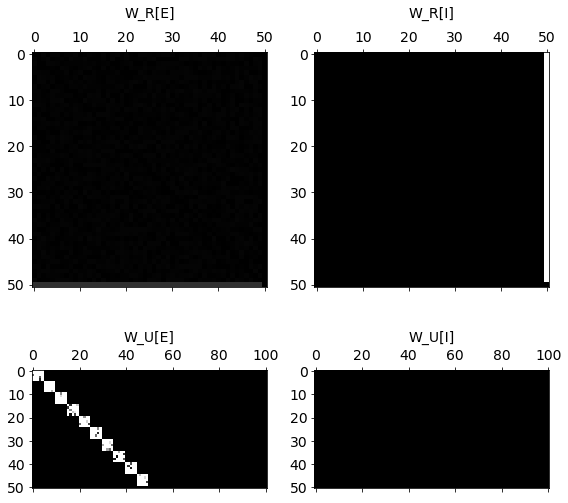

In [107]:
%%time
S.T = 50
S.DT = 0.2e-3
m2 = copy(M)
m2.EPSILON = 0.01
m2.ETA = 0.00001
m2.W_E_I_R = 1e-5
m2.W_I_E_R = m2.W_E_I_R * m2.N_EXC
m2.T_R_E = 10e-3
m2.W_MAX = 0.26 * 0.004 * 0.25
m2.M = 5
m2.W_INITIAL = m2.W_MAX / (m2.M * m2.N_EXC)

all_rsps = quick_plot(m2)

5.2000000000000004e-05
1e-05
5.2000000000000004e-05
False
CPU times: user 17min 34s, sys: 3.29 s, total: 17min 38s
Wall time: 17min 41s


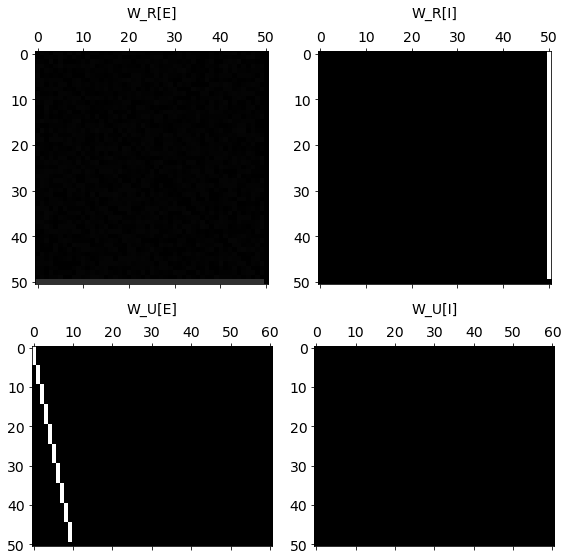

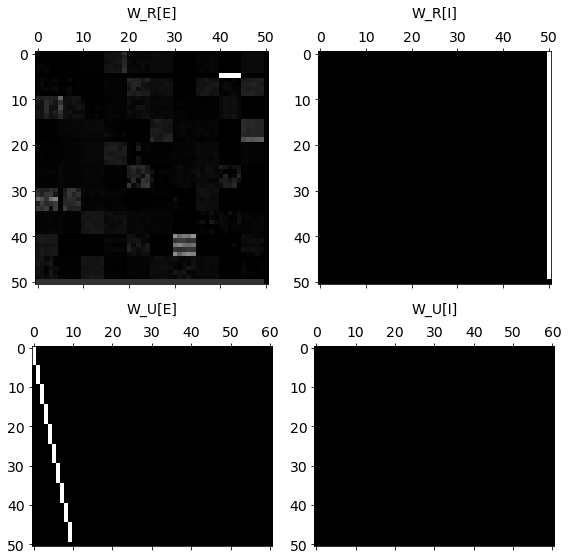

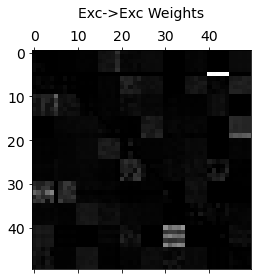

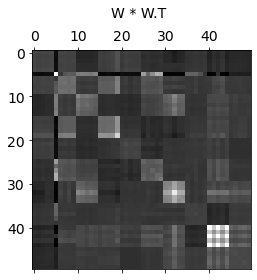

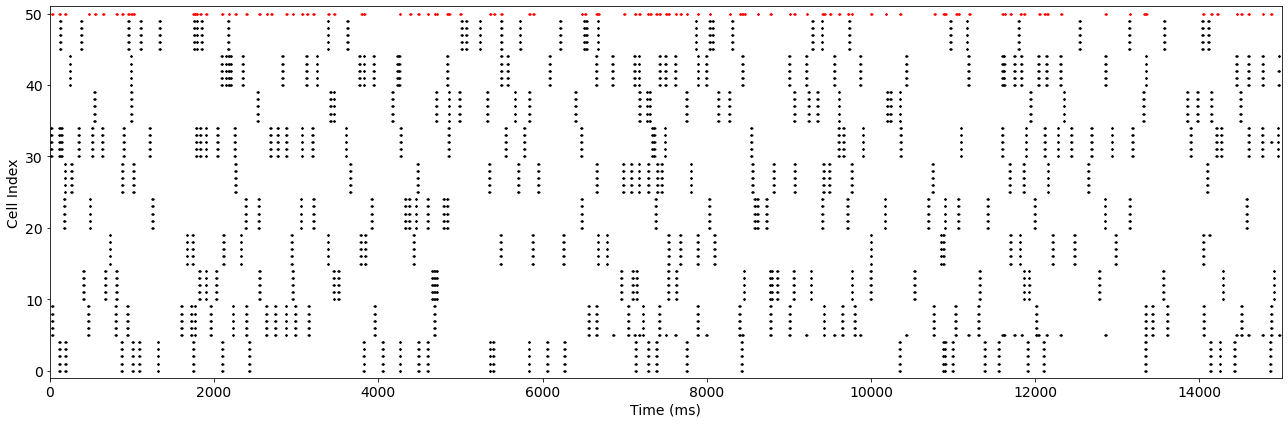

In [10]:
%%time
S.T = 15
S.DT = 0.2e-3
m2 = copy(M)
m2.EPSILON = 0.01
m2.ETA = 0.000005
m2.W_E_I_R = 1e-5
m2.W_I_E_R = m2.W_E_I_R * m2.N_EXC
m2.T_R_E = 10e-3
m2.W_MAX = 0.26 * 0.004 * 0.25
m2.M = 5
m2.W_INITIAL = m2.W_MAX / (m2.M * m2.N_EXC)

all_rsps = quick_plot(m2)

5.2000000000000004e-05
1e-05
5.2000000000000004e-05
False
CPU times: user 18min 19s, sys: 4.36 s, total: 18min 23s
Wall time: 19min 44s


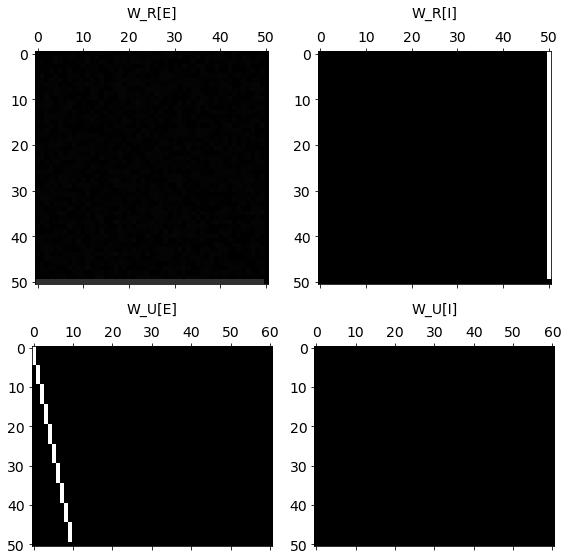

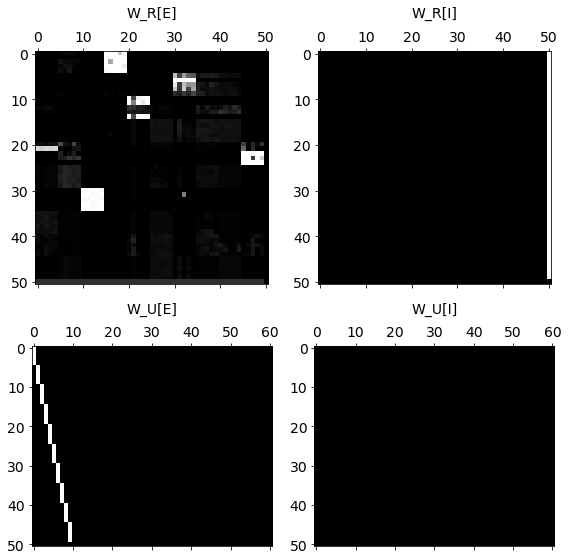

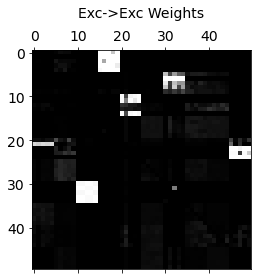

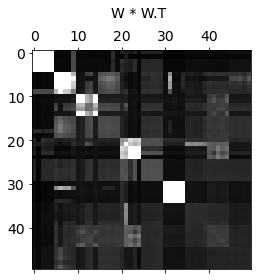

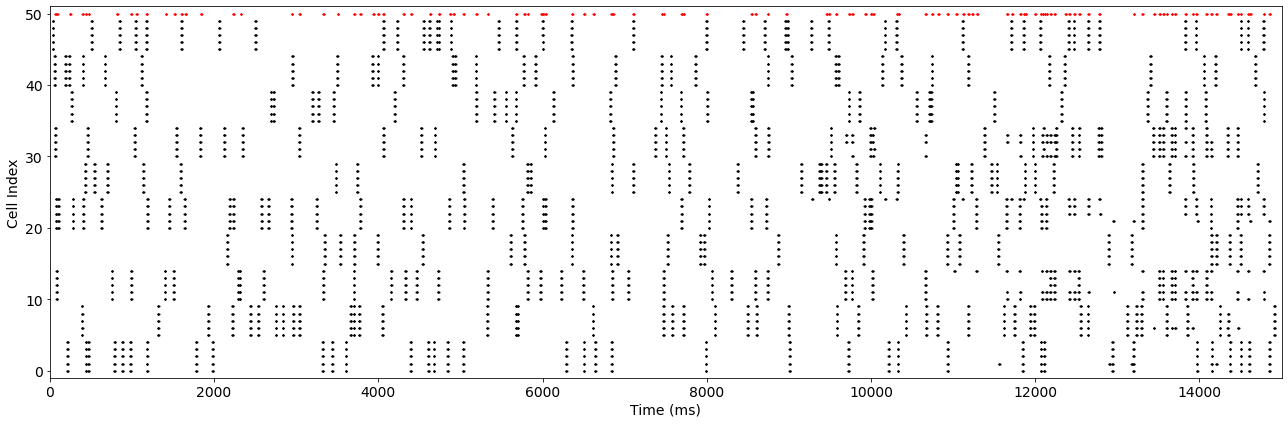

In [11]:
%%time
S.T = 15
S.DT = 0.2e-3
m2 = copy(M)
m2.EPSILON = 0.01
m2.ETA = 0.000005
m2.W_E_I_R = 1e-5
m2.W_I_E_R = m2.W_E_I_R * m2.N_EXC
m2.T_R_E = 10e-3
m2.W_MAX = 0.26 * 0.004 * 0.25
m2.M = 5
m2.W_INITIAL = m2.W_MAX / (m2.M * m2.N_EXC)

all_rsps = quick_plot(m2)

5.2000000000000004e-05
1e-05
5.2000000000000004e-05
False
CPU times: user 1h 3min 40s, sys: 21 s, total: 1h 4min 1s
Wall time: 1h 4min 24s


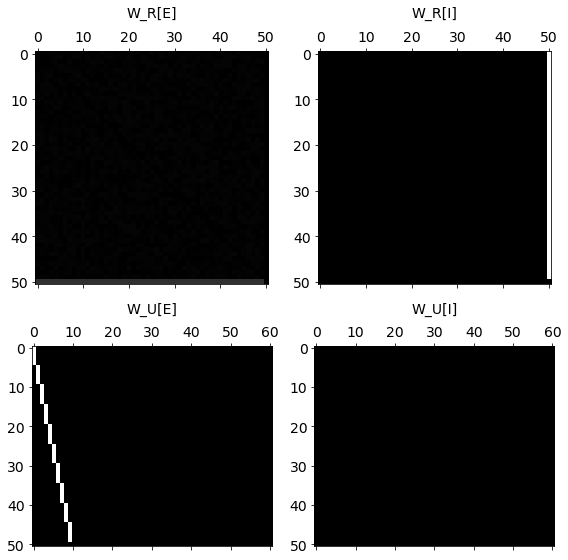

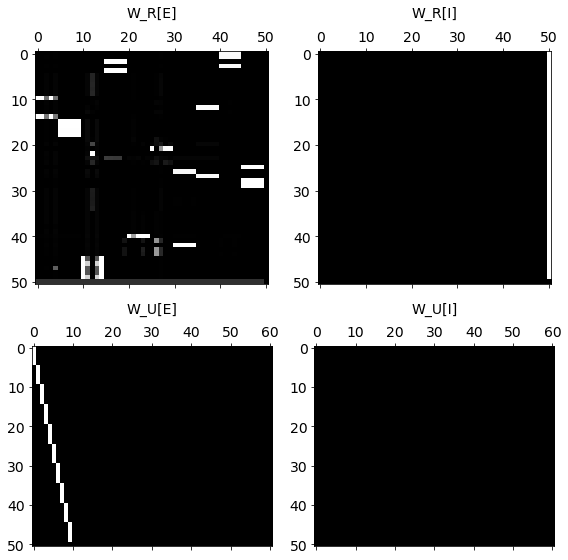

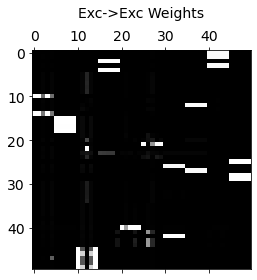

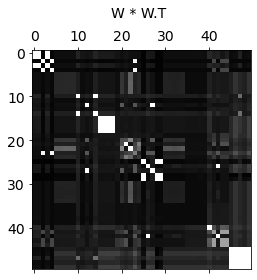

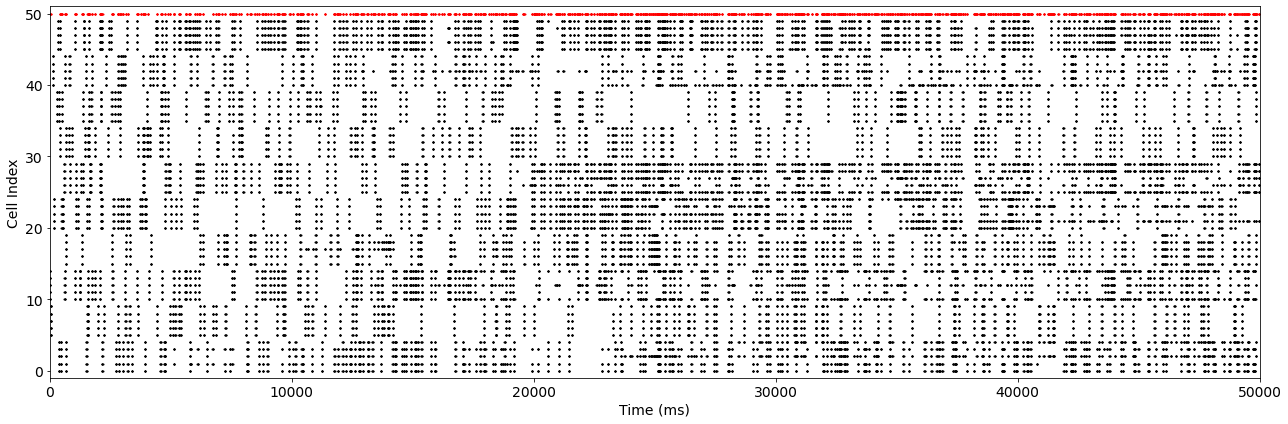

In [12]:
 %%time
S.T = 50
S.DT = 0.2e-3
m2 = copy(M)
m2.EPSILON = 0.01
m2.ETA = 0.000005
m2.W_E_I_R = 1e-5
m2.W_I_E_R = m2.W_E_I_R * m2.N_EXC
m2.T_R_E = 10e-3
m2.W_MAX = 0.26 * 0.004 * 0.25
m2.M = 5
m2.W_INITIAL = m2.W_MAX / (m2.M * m2.N_EXC)

all_rsps = quick_plot(m2)

5.2000000000000004e-05
1e-05
5.2000000000000004e-05
False
CPU times: user 1h 1min 10s, sys: 14.6 s, total: 1h 1min 25s
Wall time: 1h 1min 45s


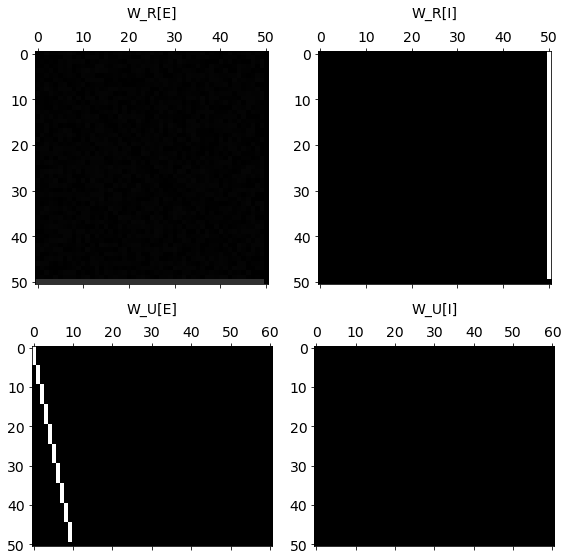

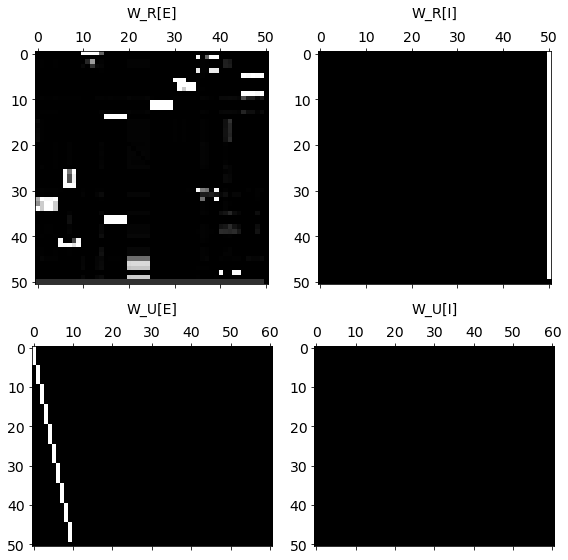

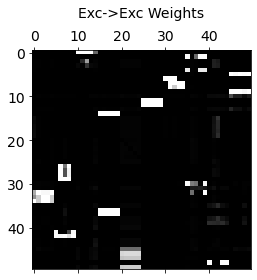

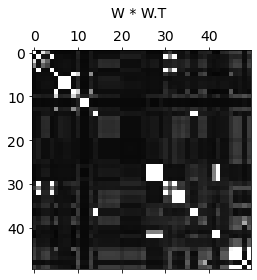

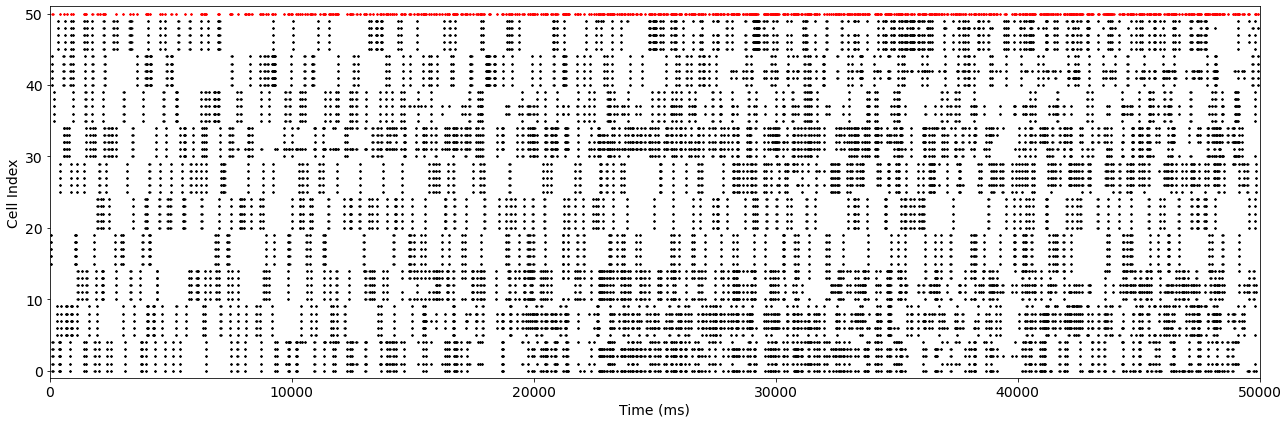

In [13]:
 %%time
S.T = 50
S.DT = 0.2e-3
m2 = copy(M)
m2.EPSILON = 0.01
m2.ETA = 0.000005
m2.W_E_I_R = 1e-5
m2.W_I_E_R = m2.W_E_I_R * m2.N_EXC
m2.T_R_E = 10e-3
m2.W_MAX = 0.26 * 0.004 * 0.25
m2.M = 5
m2.W_INITIAL = m2.W_MAX / (m2.M * m2.N_EXC)

all_rsps = quick_plot(m2)

4.160000000000001e-05
1e-05
4.160000000000001e-05
False
CPU times: user 1h 57s, sys: 11.7 s, total: 1h 1min 9s
Wall time: 1h 1min 54s


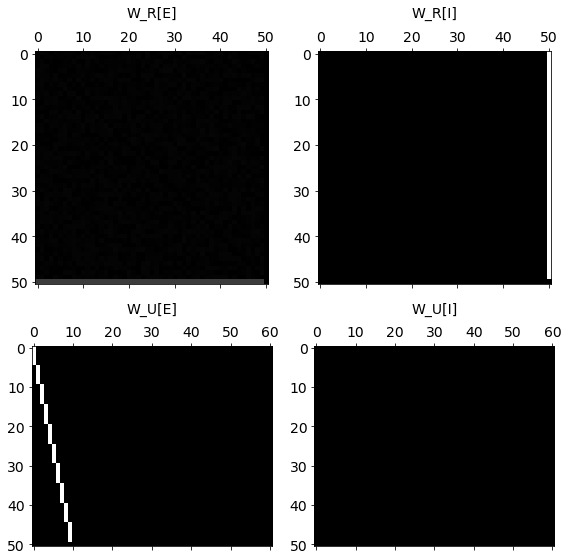

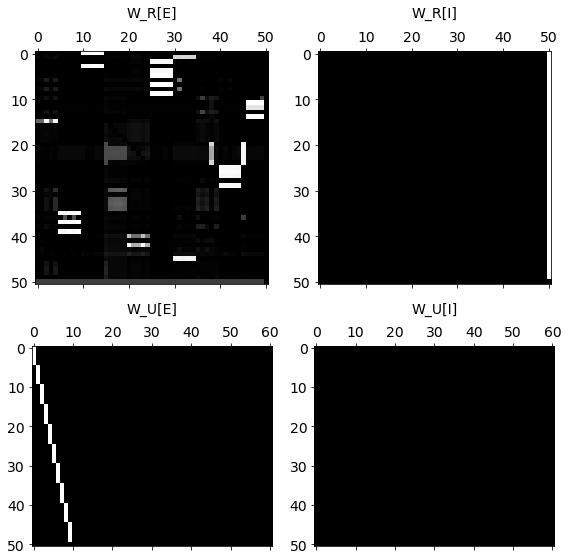

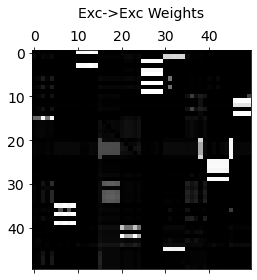

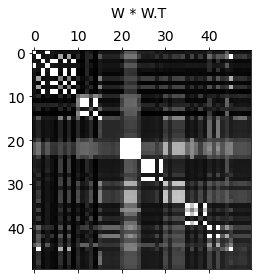

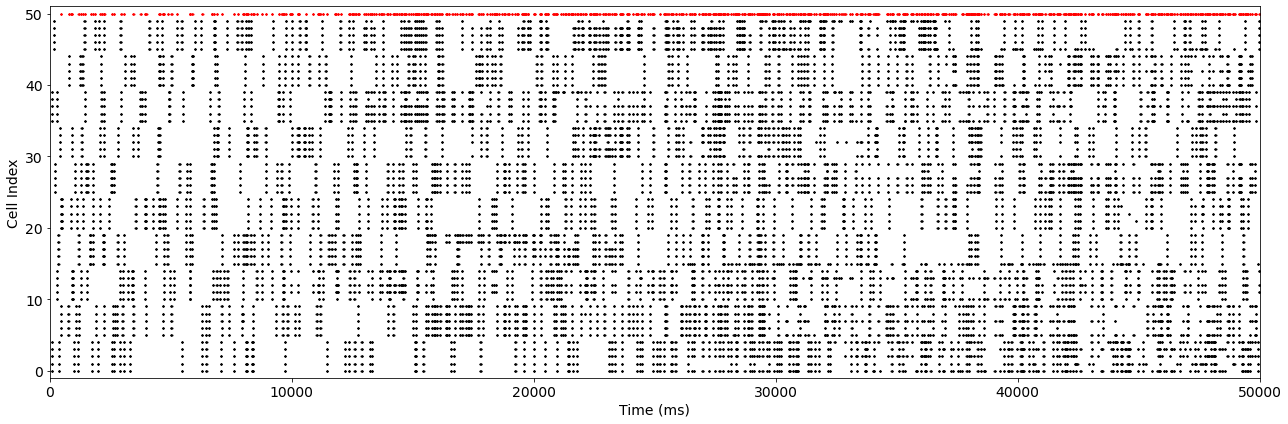

In [14]:
 %%time
S.T = 50
S.DT = 0.2e-3
m2 = copy(M)
m2.EPSILON = 0.01
m2.ETA = 0.000005
m2.W_E_I_R = 1e-5
m2.W_I_E_R = m2.W_E_I_R * m2.N_EXC
m2.T_R_E = 10e-3
m2.W_MAX = 0.26 * 0.004 * 0.2
m2.M = 5
m2.W_INITIAL = m2.W_MAX / (m2.M * m2.N_EXC)

all_rsps = quick_plot(m2)

4.160000000000001e-05
1e-05
4.160000000000001e-05
False
CPU times: user 1h 2min 34s, sys: 13.2 s, total: 1h 2min 47s
Wall time: 2h 55min 52s


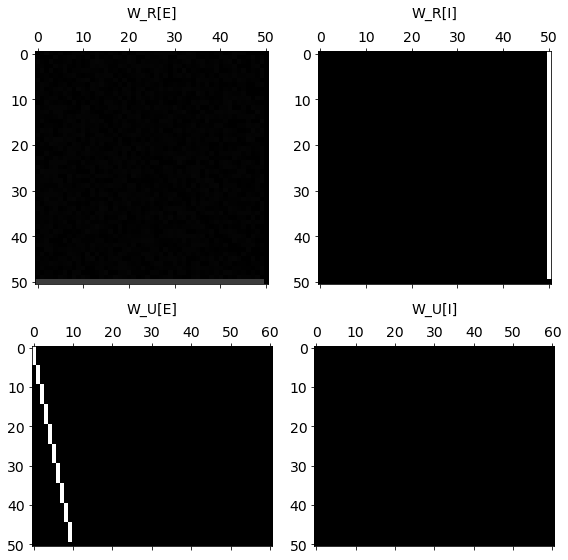

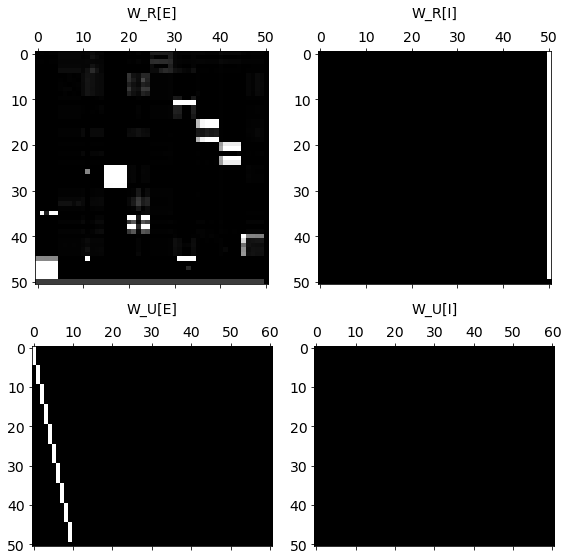

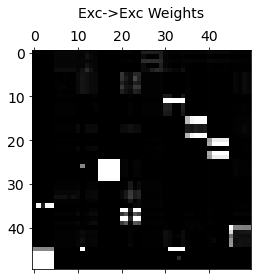

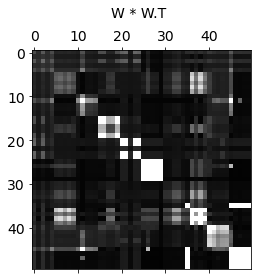

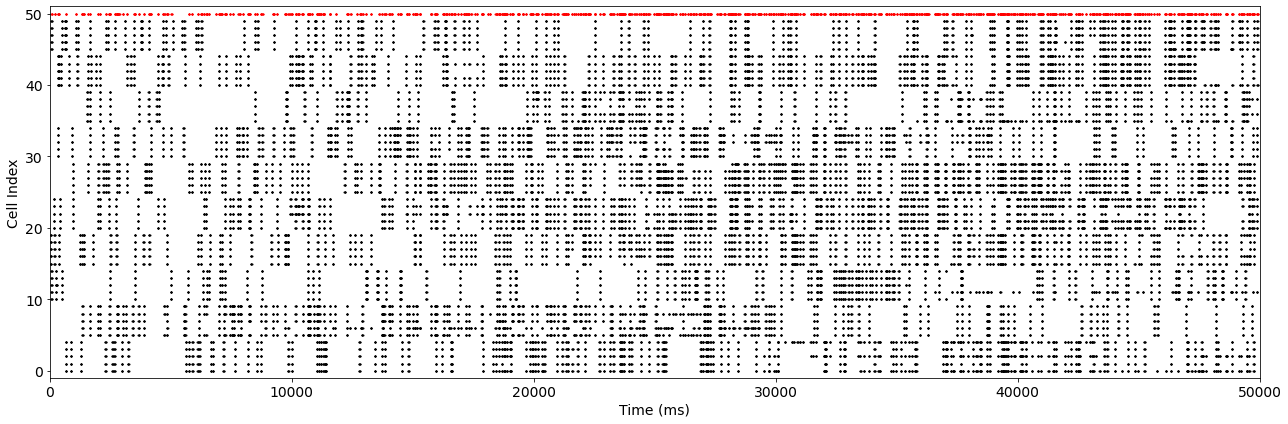

In [15]:
%%time
S.T = 50
S.DT = 0.2e-3
m2 = copy(M)
m2.EPSILON = 0.005
m2.ETA = 0.000005
m2.W_E_I_R = 1e-5
m2.W_I_E_R = m2.W_E_I_R * m2.N_EXC
m2.T_R_E = 10e-3
m2.W_MAX = 0.26 * 0.004 * 0.2
m2.M = 5
m2.W_INITIAL = m2.W_MAX / (m2.M * m2.N_EXC)

all_rsps = quick_plot(m2)

4.160000000000001e-05
1e-05
4.160000000000001e-05
False
CPU times: user 1h 13min 47s, sys: 17.3 s, total: 1h 14min 4s
Wall time: 3h 40min 11s


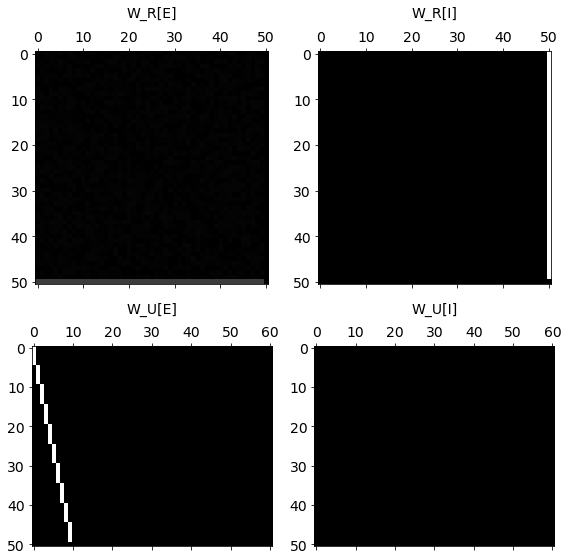

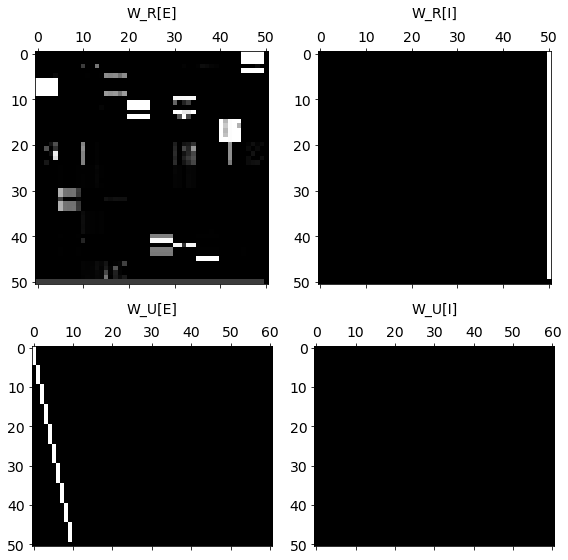

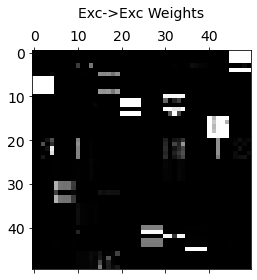

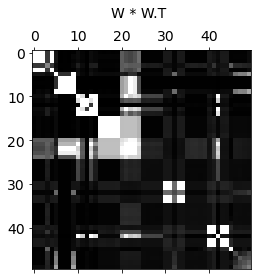

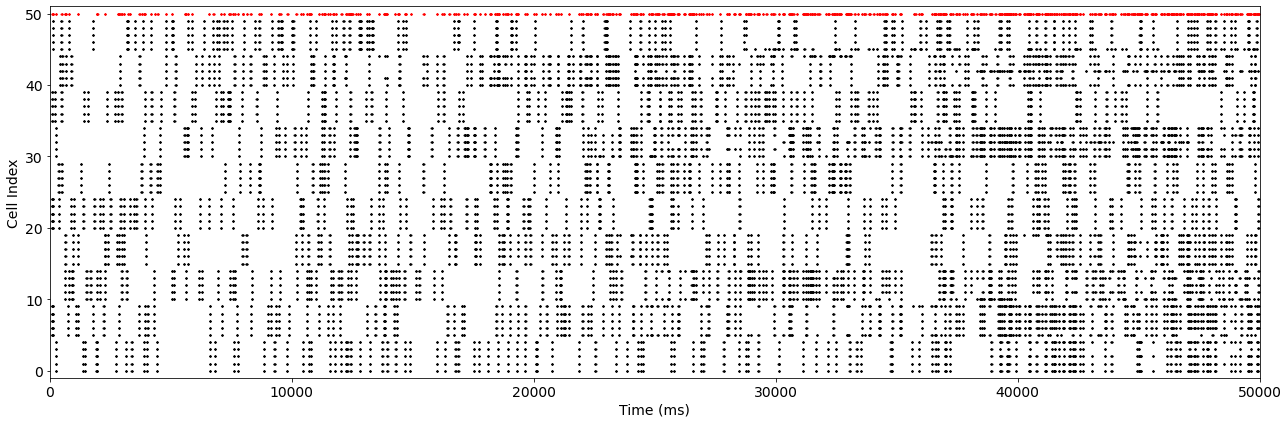

In [16]:
%%time
S.T = 50
S.DT = 0.2e-3
m2 = copy(M)
m2.EPSILON = 0.001
m2.ETA = 0.000005
m2.W_E_I_R = 1e-5
m2.W_I_E_R = m2.W_E_I_R * m2.N_EXC
m2.T_R_E = 10e-3
m2.W_MAX = 0.26 * 0.004 * 0.2
m2.M = 5
m2.W_INITIAL = m2.W_MAX / (m2.M * m2.N_EXC)

all_rsps = quick_plot(m2)

4.160000000000001e-05
1e-05
4.160000000000001e-05
False
CPU times: user 4h 40s, sys: 47.1 s, total: 4h 1min 27s
Wall time: 13h 11min 47s


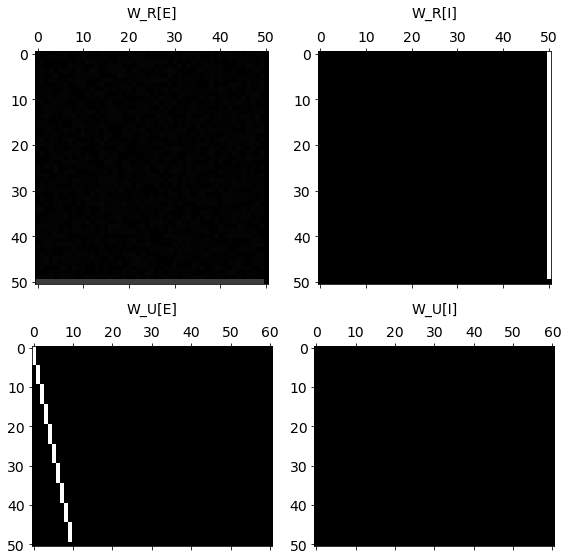

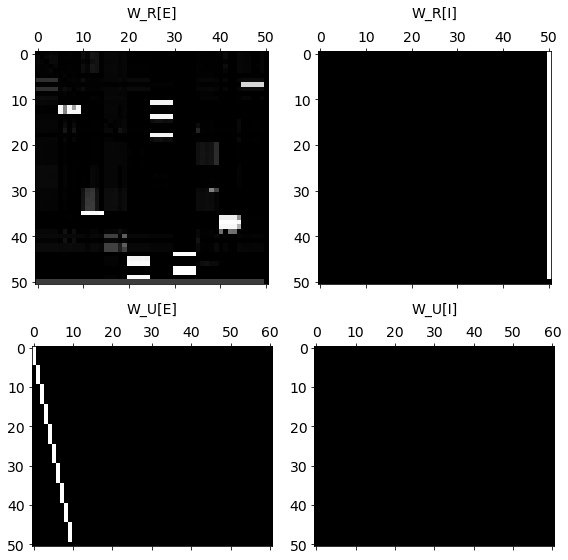

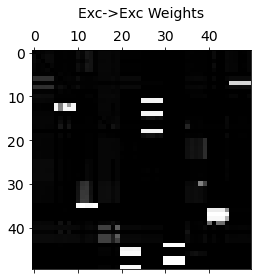

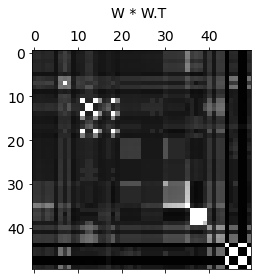

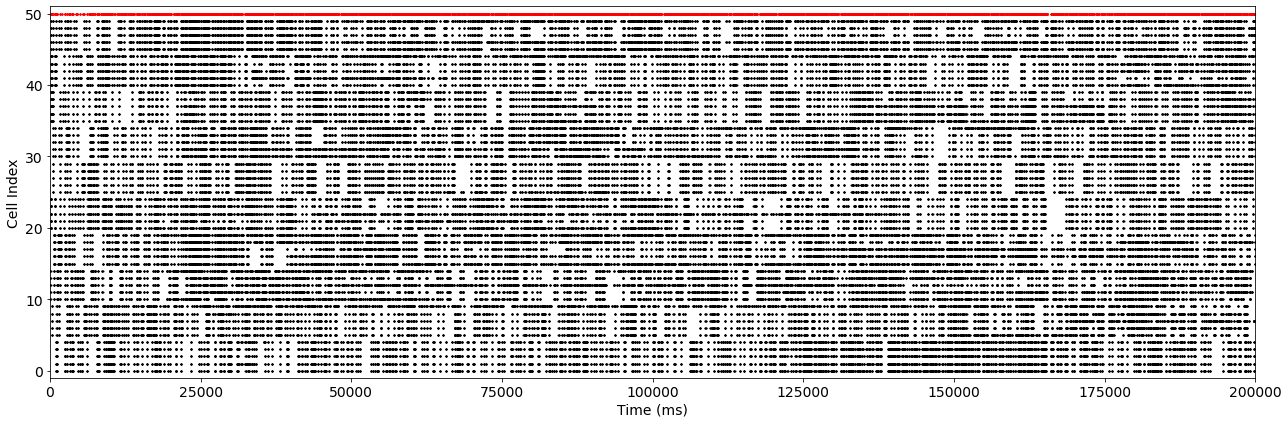

In [17]:
%%time
S.T = 200
S.DT = 0.2e-3
m2 = copy(M)
m2.EPSILON = 0.01
m2.ETA = 0.000005
m2.W_E_I_R = 1e-5
m2.W_I_E_R = m2.W_E_I_R * m2.N_EXC
m2.T_R_E = 10e-3
m2.W_MAX = 0.26 * 0.004 * 0.2
m2.M = 5
m2.W_INITIAL = m2.W_MAX / (m2.M * m2.N_EXC)

all_rsps = quick_plot(m2)

4.160000000000001e-05
1e-05


KeyboardInterrupt: 

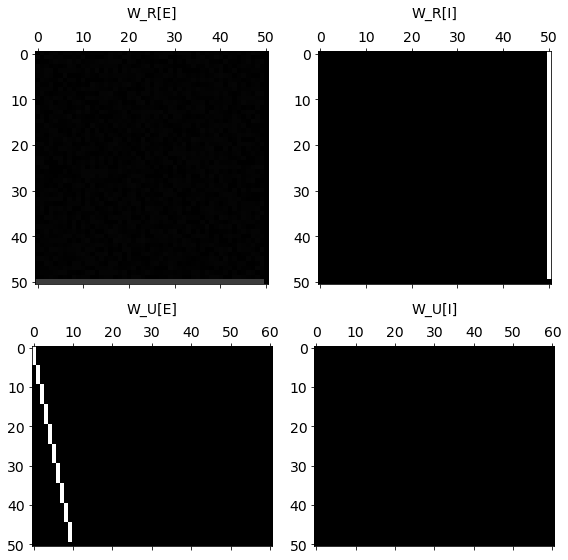

In [19]:
%%time
S.T = 20
S.DT = 0.2e-3
m2 = copy(M)
m2.EPSILON = 0.1
m2.ETA = 0.000005
m2.W_E_I_R = 1e-5
m2.W_I_E_R = m2.W_E_I_R * m2.N_EXC
m2.T_R_E = 10e-3
m2.W_MAX = 0.26 * 0.004 * 0.2
m2.M = 5
m2.W_INITIAL = m2.W_MAX / (m2.M * m2.N_EXC)

all_rsps = quick_plot(m2)

2.4959999999999998e-05
1e-05
2.4959999999999998e-05
False
CPU times: user 23min 4s, sys: 3.97 s, total: 23min 8s
Wall time: 23min 12s


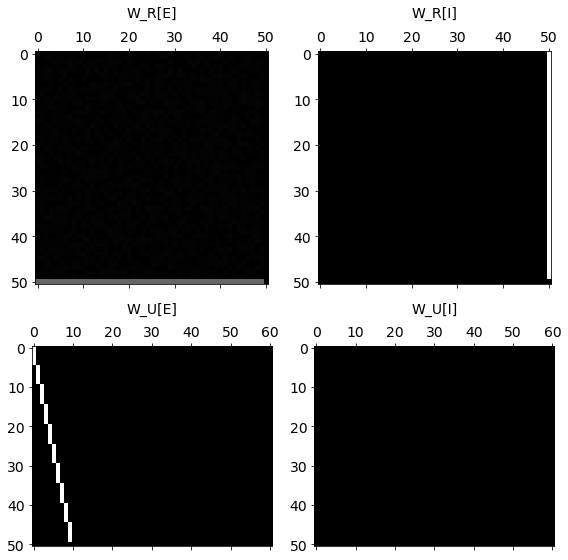

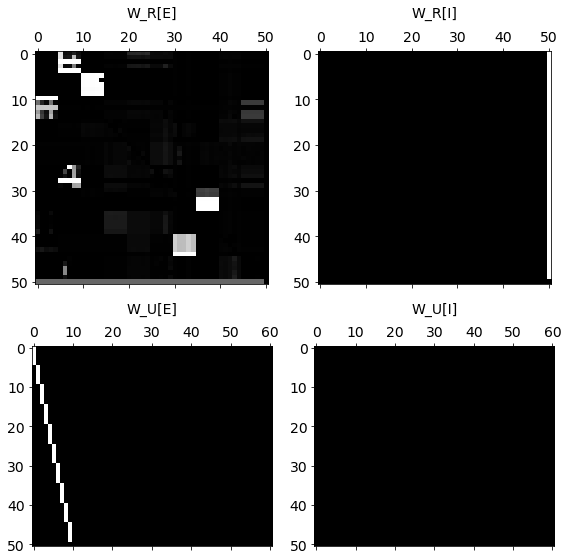

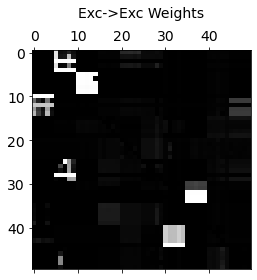

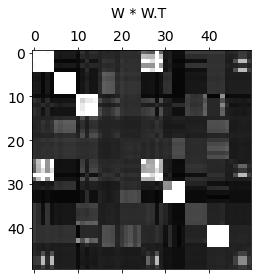

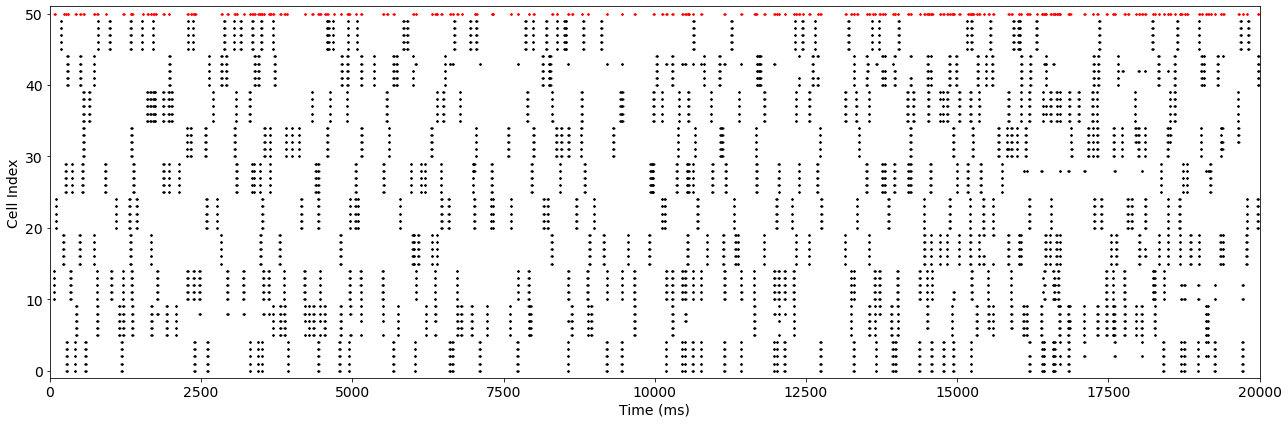

In [47]:
%%time
S.T = 20
S.DT = 0.2e-3
m2 = copy(M)
m2.EPSILON = 0.005
m2.ETA = 0.000005
m2.W_E_I_R = 1e-5
m2.W_I_E_R = m2.W_E_I_R * m2.N_EXC
m2.T_R_E = 10e-3
m2.W_MAX = 0.26 * 0.004 * 0.12
m2.M = 5
m2.W_INITIAL = m2.W_MAX / (m2.M * m2.N_EXC)

all_rsps = quick_plot(m2)

3.1200000000000006e-05
1e-05


KeyboardInterrupt: 

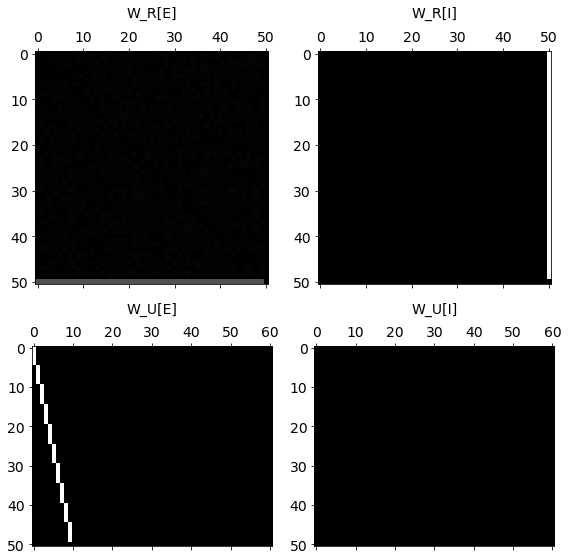

In [13]:
%%time
S.T = 100
S.DT = 0.2e-3
m2 = copy(M)
m2.EPSILON = 0.005
m2.ETA = 0.000001
m2.W_E_I_R = 1e-5
m2.W_I_E_R = m2.W_E_I_R * m2.N_EXC
m2.T_R_E = 10e-3
m2.W_MAX = 0.26 * 0.004 * 0.15
m2.M = 5
m2.W_INITIAL = m2.W_MAX / (m2.M * m2.N_EXC)

all_rsps = quick_plot(m2)

2.4959999999999998e-05
1e-05


KeyboardInterrupt: 

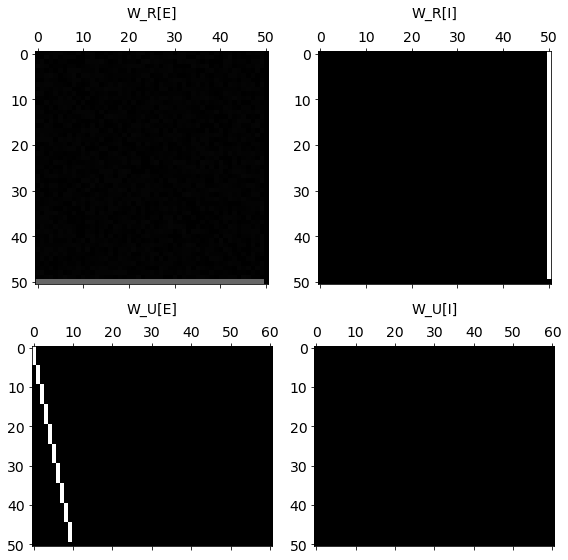

In [10]:
%%time
S.T = 200
S.DT = 0.2e-3
m2 = copy(M)
m2.EPSILON = 0.005
m2.ETA = 0.000001
m2.W_E_I_R = 1e-5
m2.W_I_E_R = m2.W_E_I_R * m2.N_EXC
m2.T_R_E = 10e-3
m2.W_MAX = 0.26 * 0.004 * 0.12
m2.M = 5
m2.W_INITIAL = m2.W_MAX / (m2.M * m2.N_EXC)

all_rsps = quick_plot(m2)

4.160000000000001e-05
1e-05
3.3843594035092235e-06
False
CPU times: user 1h 26min 43s, sys: 21.3 s, total: 1h 27min 4s
Wall time: 2h 23min 20s


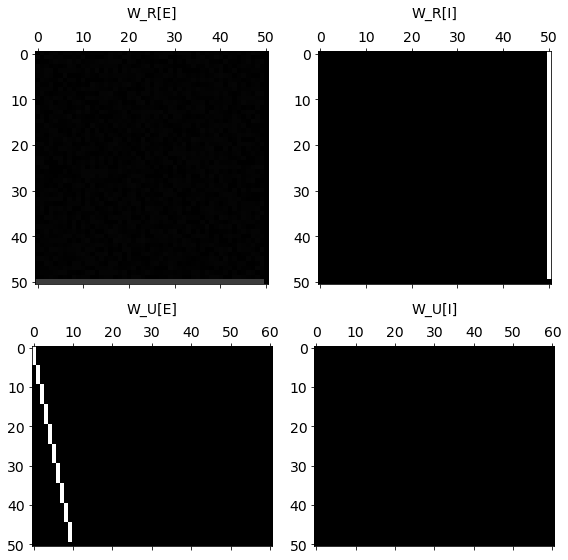

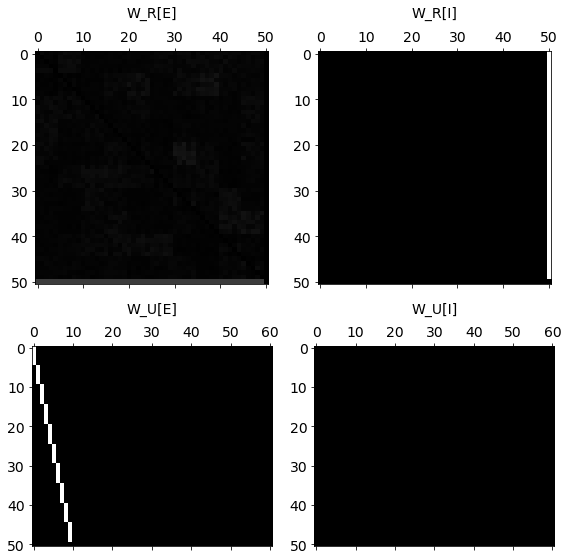

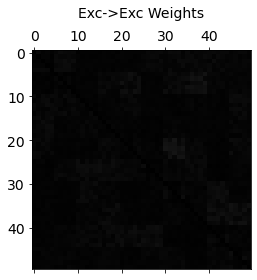

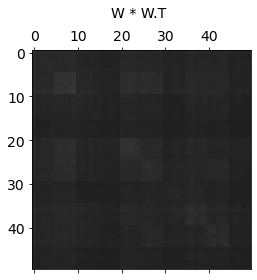

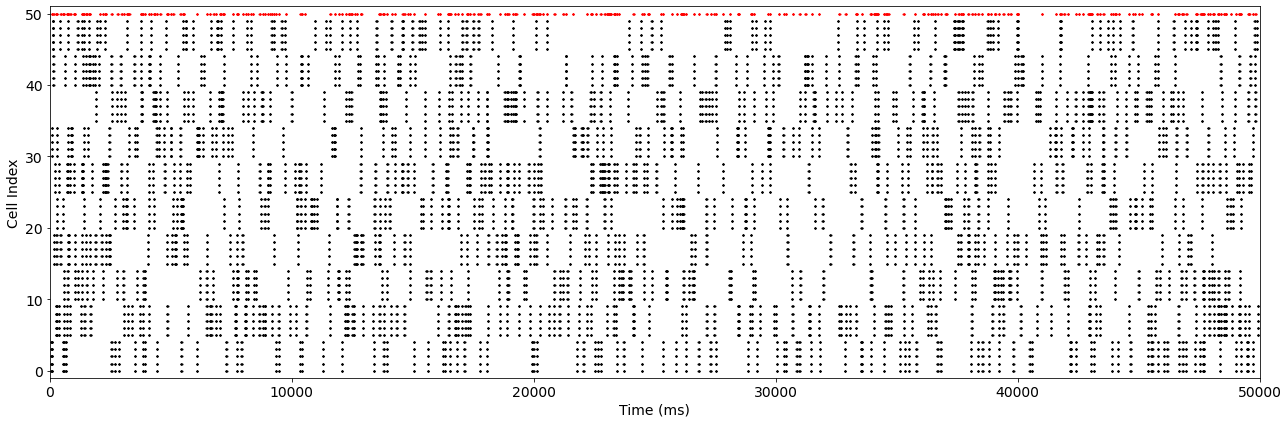

In [10]:
%%time
S.T = 50
S.DT = 0.2e-3
m2 = copy(M)
m2.EPSILON = 0.005
m2.ETA = 0.000001
m2.W_E_I_R = 1e-5
m2.W_I_E_R = m2.W_E_I_R * m2.N_EXC
m2.T_R_E = 10e-3
m2.W_MAX = 0.26 * 0.004 * 0.2
m2.M = 5
m2.W_INITIAL = m2.W_MAX / (m2.M * m2.N_EXC)

all_rsps = quick_plot(m2)

False
CPU times: user 11min 36s, sys: 2.63 s, total: 11min 39s
Wall time: 11min 41s


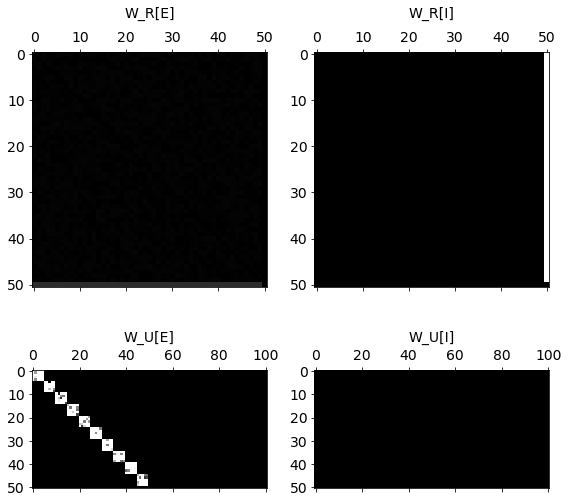

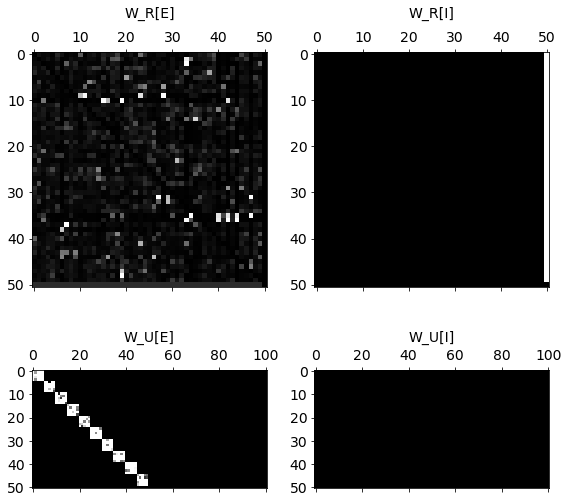

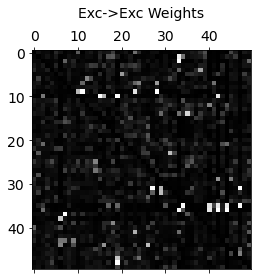

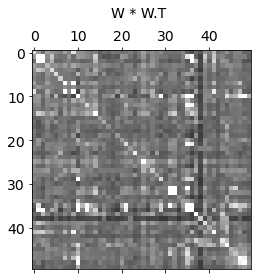

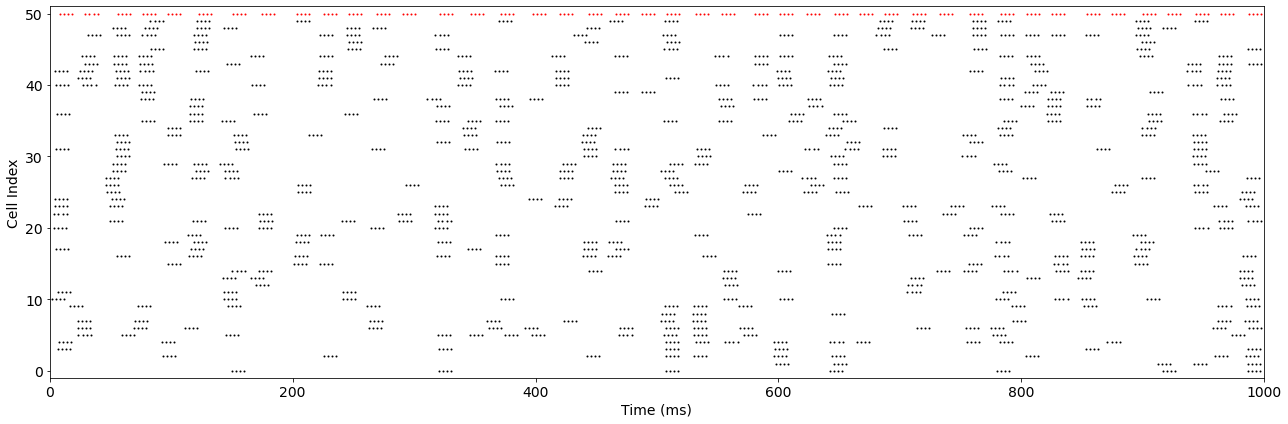

In [114]:
%%time
S.T = 1
S.DT = 0.02e-3
m2 = copy(M)
m2.EPSILON = 0.01
m2.ETA = 0.00001
m2.W_E_I_R = 1e-5
m2.W_I_E_R = m2.W_E_I_R * m2.N_EXC
m2.T_R_E = 10e-3
m2.W_MAX = 0.26 * 0.004 * 0.5
m2.M = 9
m2.W_INITIAL = m2.W_MAX / (m2.M * m2.N_EXC)

all_rsps = quick_plot(m2)

In [ ]:
%%time
S.T = 5
S.DT = 0.02e-3
m2 = copy(M)
m2.EPSILON = 0.01
m2.ETA = 0.000001
m2.W_E_I_R = 1e-5
m2.W_I_E_R = m2.W_E_I_R * m2.N_EXC
m2.T_R_E = 10e-3
m2.W_MAX = 0.26 * 0.004 * 0.5
m2.M = 9
m2.W_INITIAL = m2.W_MAX / (m2.M * m2.N_EXC)

all_rsps = quick_plot(m2)

In [ ]:
%%time
S.T = 1.
S.DT = 0.02e-3
m2 = copy(M)
m2.EPSILON = 0.
m2.ETA = 0.0001
m2.W_E_I_R = 1e-5
m2.W_I_E_R = m2.W_E_I_R * m2.N_EXC
m2.T_R_E = 10e-3
m2.W_MAX = 0.26 * 0.004 * 0.5
m2.M = 9
m2.W_INITIAL = m2.W_MAX / (m2.M * m2.N_EXC)

all_rsps = quick_plot(m2)

False
CPU times: user 11min 38s, sys: 2.25 s, total: 11min 40s
Wall time: 11min 43s


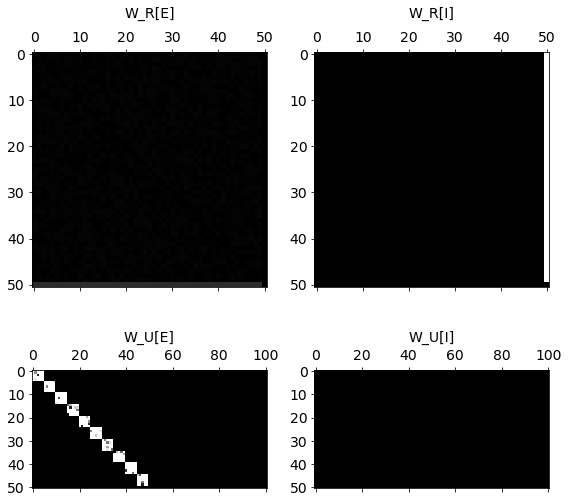

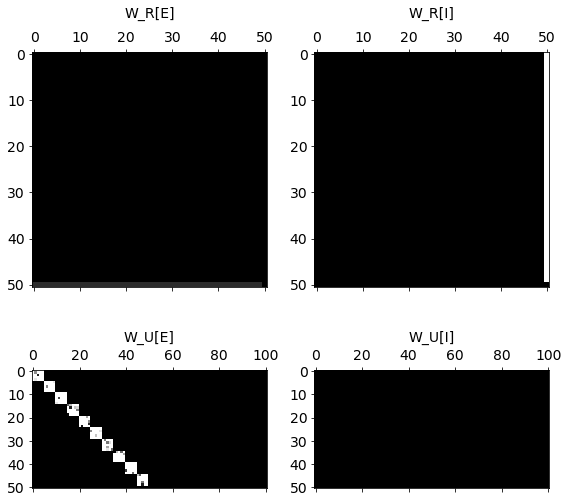

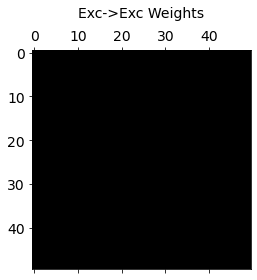

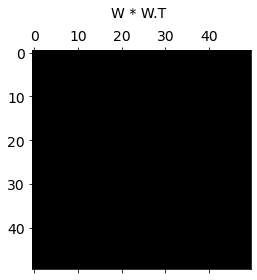

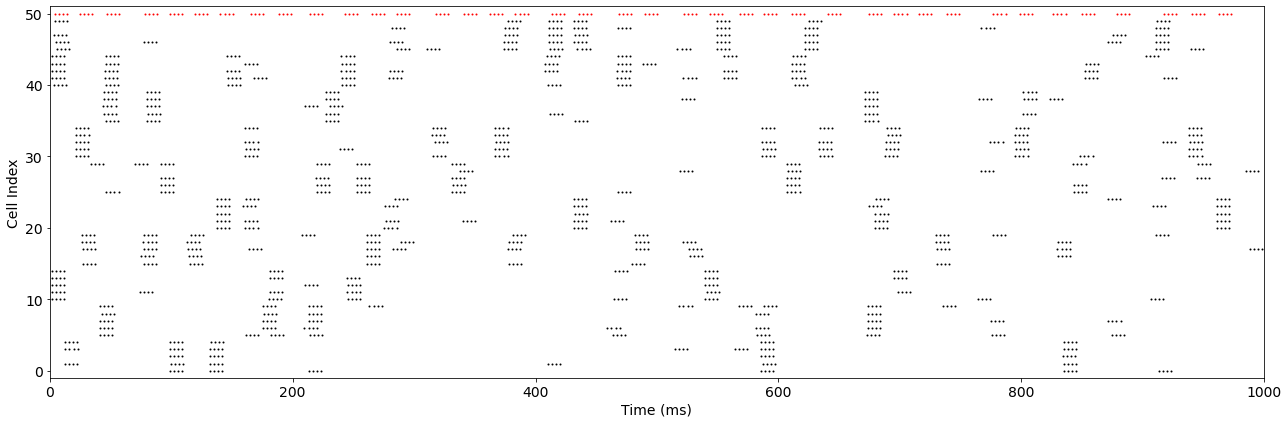

In [10]:
%%time
S.T = 1.
S.DT = 0.02e-3
m2 = copy(M)
m2.EPSILON = 0.3
m2.ETA = 0.0001
m2.W_E_I_R = 1e-5
m2.W_I_E_R = m2.W_E_I_R * m2.N_EXC
m2.T_R_E = 10e-3
m2.W_MAX = 0.26 * 0.004 * 0.5
m2.M = 9
m2.W_INITIAL = m2.W_MAX / (m2.M * m2.N_EXC)

all_rsps = quick_plot(m2)